In [23]:
#se importan los paquetes necesarios
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from ipywidgets import interact
from sympy.solvers import solve, linsolve
from sympy import Symbol
from sympy import symarray
from itertools import combinations

In [24]:
#se crea la función que calculará r efectiva
def f_reff(i,x,params):
    r,b,c = params
    
    N=len(r)
        
    r_eff = r[i] 
    for j in range(N):
        r_eff = r_eff + b[i][j]*x[j]
        
    return r_eff

In [25]:
#encontrar las soluciones estacionarias de las ecuaciones de r_eff y las combinaciones de x=1/c
def solut_fact_reff_Nsp2(params):
    r,b,c = params  #se introducen los parámetros en el modelo
    N=len(r)
    
    if any(c[i]==0 for i in range(N)):  #se comprueba que ningun valor de c sea 0
        print('c=0')
        return

    x=symarray("x", N)
    #se generan listas donde posteriormente se almacenarán diversos datos de interés
    r_ef=[]
    x_n=[]
    dx_n=[]
    sols=[]
    Sols=[]
    Sols_dict={}
    ind_cc_dict={}  # diccionario que contiene 0/1 para cada combinación, siendo 1: variable=1/c
    
    for i in range(N):
        r_eff = r[i] 
        for j in range(N):
            r_eff = r_eff + b[i][j]*x[j]  #se calcula r efectiva
        dx = r_eff * x[i]*(1-c[i]*x[i])   #se crea la ecuación con esa r efectiva
        r_ef.append(r_eff)  #se almacena la r efectiva
        dx_n.append(dx)   #se almacena toda la ecuación para esa especie
        x_n.append(x[i])  #se guarda la especie que ese esta estudiando, por ejemplo x_1
    
    sol_cc = [1./c[i] for i in range(N)] #se calculan las carrying capacities 
        
    for nfix in range(0,N): #Se evaluarán las combinaciones posibles cogiendo desde 1 especie hasta N-1 especies, que será el total         
        comb_fix = np.math.factorial(N)/(np.math.factorial(nfix)*np.math.factorial(N-nfix))
        combinat = list(combinations(range(N),nfix)) #se generan las combinaciones de 0 y 1 para nfix, siendo 1 las especies que están en carrying capacity
        Sols=[]
        ind_cc=[]
        for list_fix in combinat:           
            i_cc=[]        
            Eqs=[]
            Xs=[]        
            i_cc = [ 1 if i in list_fix else 0 for i in range(N)]
            for i in range(N):
                if i not in list_fix: #se calculan las ecuaciones de las variables que no están en carrying capacity
                    eq = r_ef[i]
                    for k in list_fix:
                        eq = eq.subs({x[k]:sol_cc[k]})
                    Eqs.append(eq) #se almacena la ecuación generada
                    Xs.append(x[i])                  
                        
            sol_lin = next(iter(linsolve(Eqs,Xs))) #se resuelven las ecuaciones
            sol=[]
            for s in sol_lin:
                sol.append(s)  #se almacenan las soluciones
        
            if sol: #se generará la solución completa, mezclando las soluciones calculadas y las que estan en carrying capacity
                j = 0
                i_cc = [0 for i in range(N)]
                X_fin=[]
                for i in range(N):                    
                    if i in list_fix:
                        X_fin.append(sol_cc[i])
                        i_cc[i]=1  #está en carrying capacity
                    else:
                        X_fin.append(np.float(sol[j]))
                        j +=1
                        i_cc[i]=0  #no está en carrying capacity
                        
                Sols.append(X_fin)  #se almacena la solución entera
                ind_cc.append(i_cc) #se almacená el vector con las especies que están en carrying capacity
                                
        Sols_dict[nfix]= Sols                                
        ind_cc_dict[nfix] = ind_cc
        
    Sols_dict[N] = [ [sol_cc[i] for i in range(N)] ]
    ind_cc_dict[N] = [[1 for i in range(N)]]
    
    Sols_uniq_dict={}
    ind_cc_uniq_dict={}
    for nfix in range(0,N+1):
        ss=0
        Sols_uniq=[]
        ind_cc_uniq=[]
        for s in Sols_dict[nfix]:
            if s not in Sols_uniq:    #se eliminan posiibles soluciones repetidas        
                if all([s[i]>0 for i in range(N) if len(s)>1]):  #se comprueba que todos los valores de la solción sean mayores que 0
                    Sols_uniq.append(s)
                    ind_cc_uniq.append(ind_cc_dict[nfix][ss])
            ss +=1
            
        Sols_uniq_dict[nfix]=Sols_uniq   #lista de soluciones con todos sus valores por encima de 0
        ind_cc_uniq_dict[nfix]=ind_cc_uniq   #lista de vectores que indican qué especies estan en la carrying capacity en cada solución
        #print('nfix: ',nfix)
        #print('Sols_unique_dict: ', Sols_uniq_dict[nfix])
        #print('ind_cc_uniq_dict: ', ind_cc_uniq_dict[nfix])
    
    return(Sols_uniq_dict, ind_cc_uniq_dict)

In [26]:
#función que calcula la matriz Jacobiana cuando ninguna especie está en carrying capacity
def Jacobian_fact_X0_Nsp(X,params):
    r,b,c = params
    
    N=len(r)
    JJ = np.ndarray(shape=(N,N), dtype=float)
    
    for i in range(N):
        for j in range(N):
            JJ[i][j] = b[i][j]*X[i]*(1. - c[i]*X[i]) #se calcula cada valor de la matriz
    
    return JJ

In [27]:
#función que calcula la matriz Jacobiana cuando todas las especies están en carrying capacity
def Jacobian_fact_1C_Nsp(X,params):
    r,b,c = params
    
    N=len(r)
    x_c= np.zeros((N,))
    r_eff = np.zeros((N,))

    for i in range(N):
        r_eff[i]=f_reff(i,X,params)
        
    JJ = np.zeros(shape=(N,N), dtype=float) #se genera la matriz con todos los valores como 0
    for i in range(N):
            JJ[i][i] = -r_eff[i]  #se calcula la diagonal de la matriz que será la única que no sea 0
    return JJ

In [28]:
#función que calcula la matriz Jacobiana cuando hay mezcla de especies en carrying capacity y especies que no.
def Jacobian_fact_1C_X_Nsp(X,cc,params):
    r,b,c = params
    
    N=len(r)
    JJ_cc = np.zeros(shape=(N,N), dtype=float)  #se genera una matriz con todos los valores como 0
    for i in range(N): #para cada fila se estudia cada caso
        if cc[i]: #en carrying capacity
            for j in range(N):
                if j == i:
                    JJ_cc[i][j] = -f_reff(j,X,params)  #se calcula el valor para esa posición
                    
        else:  #no en carrying capacity
            for j in range(N):
                JJ_cc[i][j] = b[i][j]*X[i]*(1.-c[i]*X[i]) #se calcula el valor para esa posición

    return JJ_cc

In [29]:
#función que permite calcular los autovectores de cada solución
def lambdas_fact_X_icc_Nsp(X,i_cc,params):
    list_0 = []
    list_1 = []
    for i in range(len(params[0])):
        list_0.append(0) 
        list_1.append(1)
    if i_cc == list_0:  #ninguna especie esta en carrying capacity
        JJ = Jacobian_fact_X0_Nsp(X,params)
    elif i_cc == list_1:    #todas las especies estan en carrying capacity    
        JJ = Jacobian_fact_1C_Nsp(X,params)
    else:   #mezcla de especies en carrying capacity
        JJ = Jacobian_fact_1C_X_Nsp (X,i_cc,params)
  

    lambdas=np.linalg.eigvals(JJ) #se calculan los autovalores
    return lambdas

In [20]:
#se introducen los parámetros deseados, en este caso son los de los OTUs 2,5 y 6 ya modificados para ser estables
r=[0.25, 0.6, 0.5]
b=[[0.04,-0.18,0.01], [0.12,-0.22,0.19], [0.1,0.36,-0.29]]
c=[0.0001, 0.0001,0.0001]
N= len(r)    
params=(r,b,c)
sols_fact_dict, sols_cc_dict = solut_fact_reff_Nsp2(params) #se calculan las soluciones estacionarias

In [21]:
X_finite=[]
Xss=[]
Lss=[]
print(sols_cc_dict)
for (ns,list_sols),(ni,list_cc) in zip(sols_fact_dict.items(), sols_cc_dict.items()):
    if list_sols:        
        print('n_cc:', ns, 'n_sols:', len(list_sols))
        for X,i_cc in zip(list_sols,list_cc): #se barre la lista de soluciones y de vectores de carrying capacity
            print('X:',X, 'i_cc:',i_cc)
            X_finite.append(X)
            lambdas = lambdas_fact_X_icc_Nsp(X,i_cc,params) #se calculan los autovalores
            if all(lambdas[i].real<0 for i in range(len(lambdas))): #se mira si todos tienen parte real negativa
                print('ESTABLE')
                Xss.append([X[i] for i in range(len(X))])  #se almacena la solución estable
                Lss.append([lambdas[i] for i in range(len(lambdas))])    #se almacena qué especies están en carrying capacity en esa solución

{0: [], 1: [[0, 1, 0]], 2: [[1, 1, 0], [1, 0, 1], [0, 1, 1]], 3: [[1, 1, 1]]}
n_cc: 1 n_sols: 1
X: [38565.27777777777, 10000.0, 25713.88888888889] i_cc: [0, 1, 0]
n_cc: 2 n_sols: 3
X: [10000.0, 10000.0, 15863.793103448277] i_cc: [1, 1, 0]
X: [10000.0, 14093.636363636364, 10000.0] i_cc: [1, 0, 1]
X: [42493.75, 10000.0, 10000.0] i_cc: [0, 1, 1]
ESTABLE
n_cc: 3 n_sols: 1
X: [10000.0, 10000.0, 10000.0] i_cc: [1, 1, 1]


In [12]:
#ejemplo de barrido de b14 delos OTUs 2,5 y 6 modificados
rango= np.linspace(-1,1,101,dtype=list)
for i in range(len(rango)):
    rango[i]=round(rango[i],2) #se crea el rango de 100 valores entre -1 y 1 que se va a utilizar para el barrido

#f_out = open('sol_b14','a')
#f_out.write("r=[0.25, 0.6, 0.5, 0.35]\nb=[[0.04,-0.18,0.01,i], [0.12,-0.22,0.19,0], [0.1,0.36,-0.29,0], [0,0,0,-0.01]]\nc=[0.0001,0.0001,0.0001,0.0001]\n\n")
#f_out.close()
    
for i in rango:
    #para cada valor, se seguirán los mismos pasos mostrados para el cálculo de una solución
    r=[0.25, 0.6, 0.5, 0.35]
    b=[[0.04,-0.18,0.01,i], [0.12,-0.22,0.19,0], [0.1,0.36,-0.29,0], [0,0,0,-0.01]]
    c=[0.0001, 0.0001,0.0001,0.0001]
    N= len(r)    
    params=(r,b,c)
    sols_fact_dict, sols_cc_dict = solut_fact_reff_Nsp2(params)
    Xss=[]
    l=[]
    c=[]
    X_finite=[]
    for (ns,list_sols),(ni,list_cc) in zip(sols_fact_dict.items(), sols_cc_dict.items()):
        for X,i_cc in zip(list_sols,list_cc):
            lambdas = lambdas_fact_X_icc_Nsp(X,i_cc,params)
            X_finite.append(X)
            if all(lambdas[i].real<0 for i in range(len(lambdas))):
                Xss.append(X)
                l.append(lambdas)
                c.append(i_cc)
    if len(Xss) != 0:
        #f_out = open('sol_b14','a')
        for i in range(len(Xss)):
            print(b[0][3])  #valor dado al parámetro bij
            print(sum(Xss[i]))  #total de población
            print(c[i])  #especies en carrying capacity
            print(max(l[i].real))  #autovalor menos negativo
            print(min(l[i].real))  #autovalor más negativo
            print('\n')
       
            #f_out.write(str(b[1][3])+ '\t')
            #f_out.write(str(sum(Xss[i]))+'\t')
            #f_out.write(str(c[i])+'\t')
            #f_out.write(str(max(l[i].real))+'\t')
            #f_out.write(str(min(l[i].real))+'\n')
        #f_out.close()
        

0.0
62528.75
[0, 1, 1, 0]
-0.34877500000000006
-5523.125156250001


0.02
67493.75
[0, 1, 1, 1]
-100.35
-4449.875


0.04
62493.75
[0, 1, 1, 1]
-300.35
-3949.875


0.06
57493.75
[0, 1, 1, 1]
-500.35
-3449.875


0.08
52493.75
[0, 1, 1, 1]
-700.35
-2949.875


0.1
47493.75
[0, 1, 1, 1]
-524.37515625
-2449.875


0.12
42493.75
[0, 1, 1, 1]
-124.62515625000006
-1949.875


0.14
40000.0
[1, 1, 1, 1]
-100.25000000000023
-1700.5


0.16
40000.0
[1, 1, 1, 1]
-300.25
-1700.5


0.18
40000.0
[1, 1, 1, 1]
-500.25
-1700.5


0.2
40000.0
[1, 1, 1, 1]
-700.25
-1900.35


0.22
40000.0
[1, 1, 1, 1]
-900.25
-2100.35


0.24
40000.0
[1, 1, 1, 1]
-900.5999999999999
-2300.35


0.26
40000.0
[1, 1, 1, 1]
-900.5999999999999
-2500.35


0.28
40000.0
[1, 1, 1, 1]
-900.5999999999999
-2700.3500000000004


0.3
40000.0
[1, 1, 1, 1]
-900.5999999999999
-2900.35


0.32
40000.0
[1, 1, 1, 1]
-900.5999999999999
-3100.35


0.34
40000.0
[1, 1, 1, 1]
-900.5999999999999
-3300.3500000000004


0.36
40000.0
[1, 1, 1, 1]
-900.599999999999

In [64]:
#obtención de curvas isoclinas
r=[0.25, 0.6, 0.5, 0.35]
b=[[0.04,-0.18,0.01,0], [0.12,-0.22,0.19,0.25], [0.1,0.36,-0.29,0], [0,0,0,-0.01]]
c=[0.01, 0.01,0.01,0.01]
N= len(r)    
params=(r,b,c)
sols_fact_dict, sols_cc_dict = solut_fact_reff_Nsp2(params) #se calculan las soluciones estacionarias

X_finite=[]
Xss=[]
Lss=[]
for (ns,list_sols),(ni,list_cc) in zip(sols_fact_dict.items(), sols_cc_dict.items()):
    if list_sols:        
        for X,i_cc in zip(list_sols,list_cc): #se barre la lista de soluciones y de vectores de carrying capacity
            X_finite.append(X)
            lambdas = lambdas_fact_X_icc_Nsp(X,i_cc,params) #se calculan los autovalores
            if all(lambdas[i].real<0 for i in range(len(lambdas))): #se mira si todos tienen parte real negativa
                Xss.append([X[i] for i in range(len(X))])  #se almacena la solución estable
                Lss.append([lambdas[i] for i in range(len(lambdas))])    #se almacena qué especies están en carrying capacity en esa solución
print(Xss)  #Se muestran las soluciones estables

[[418.75, 100.0, 100.0, 35.0]]


In [41]:
#función que permitirá integrar las ecuaciones diferenciales para obtener la evolución temporal
def Dx_dt(x,params):  
    r,b,c = params  #introduciión de parámetros
    N=len(r)

    dx_dt=[]
    x_n=[]
    for i in range(N):
        dx = r[i] 
        for j in range(N):
            dx = dx + b[i][j]*x[j]    #cálculo de r efectiva
        dx = dx*x[i]*(1-c[i]*x[i])    #cálculo de la ecuación entera
        dx_dt.append(dx)        #se almacenan las ecuaciones
        x_n.append(x[i])        #se almacena la variable de cada ecuación (x_1,x_2....)

    return dx_dt

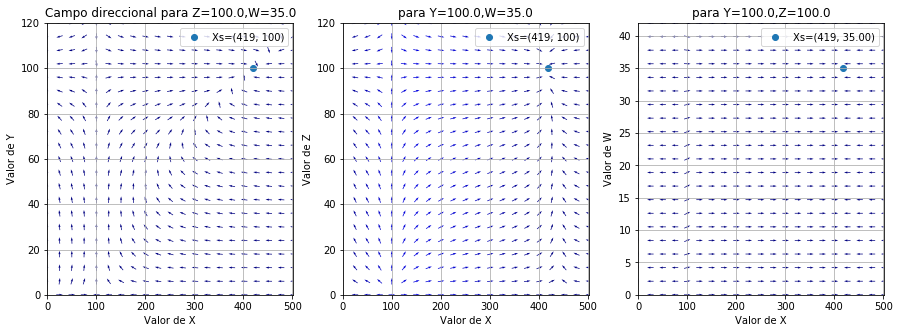

In [66]:
#seleccionar cuál de las soluciones estables se quiere representar (sol=0, sol=1,..etc)
sol=0
nb_points   = 21                      

x = np.linspace(0, round(Xss[sol][0]*1.2), nb_points)  #cambiar según la coordenada X de la solución estacionaria
y = np.linspace(0, round(Xss[sol][1]*1.2), nb_points)   #cambiar según la coordenada Y de la solución estacionaria
z = np.empty(nb_points)
z.fill(Xss[sol][2])
w = np.empty(nb_points)
w.fill(Xss[sol][3])

#se construye una malla de vectores en el plano de xy fijando z y w
X1, Y1, Z1, W1  = np.meshgrid(x, y, z, w)                       # se crea la cuadrícula

DX1,DY1,DZ1,DW1 = Dx_dt([X1, Y1, Z1, W1],params)                      # se computan los ratios de crecimiento en la cuadrícula
M1 = (np.hypot(DX1, DY1))                           # Norm of the growth rate
M1[ M1 == 0] = 1.                                 # Evitar errores por dividir entre 0 
DX1 /= M1                                        # Normalización de los vectores
DY1 /= M1                                  
XX1=X1[:,:,0,0]
YY1=Y1[:,:,0,0]
DDX1 = DX1[:,:,0,0]
DDY1 = DY1[:,:,0,0]

#se repite el proceso, esta vez se representan x y z fijando y y w
z = np.linspace(0,round(Xss[sol][2]*1.2), nb_points)
y = np.empty(nb_points)
y.fill(Xss[sol][1])

X2, Y2, Z2, W2  = np.meshgrid(x, y, z, w)                       

DX2,DY2,DZ2,DW2 = Dx_dt([X2, Y2, Z2, W2],params)                                         
M2 = (np.hypot(DX2, DZ2))                           
M2[ M2 == 0] = 1.                                 
DX2 /= M2                                        
DZ2 /= M2                                  
XX2=X2[0,:,:,0]
ZZ2=Z2[0,:,:,0]
DDX2 = DX2[0,:,:,0]
DDZ2 = DZ2[0,:,:,0]

#se vuelve a repetir el proceso, esta vez se muestra ek plano xw fijando y y z
w = np.linspace(0,round(Xss[sol][3]*1.2), nb_points)
y = np.empty(nb_points)
y.fill(Xss[sol][1])
z = np.empty(nb_points)
z.fill(Xss[sol][2])

X3, Y3, Z3, W3  = np.meshgrid(x, y, z, w)                      

DX3,DY3,DZ3,DW3 = Dx_dt([X3, Y3, Z3, W3],params)                   
M3 = (np.hypot(DX3, DW3))                           
M3[ M3 == 0] = 1.                                 
DX3 /= M3                                       
DW3 /= M3                                  
XX3=X3[0,:,0,:]
WW3=W3[0,:,0,:]
DDX3 = DX3[0,:,0,:]
DDW3 = DW3[0,:,0,:]


fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15,5),nrows=1, ncols=3, sharex=True)

#gráfico 1 xy
Q = ax1.quiver(XX1, YY1, DDX1, DDY1, M1, pivot='mid', cmap=plt.cm.jet)

ax1.scatter( Xss[0][0], Xss[0][1], label='Xs=(%.f, %.f)' % ( Xss[0][0], Xss[0][1]) )
ax1.set_title('Campo direccional para Z='+str(round(Xss[sol][2],2))+',W='+str(round(Xss[sol][3],2)))
ax1.set_xlabel('Valor de X')
ax1.set_ylabel('Valor de Y')
ax1.set_xlim((0,round(Xss[sol][0]*1.2)))
ax1.set_ylim((0,round(Xss[sol][1]*1.2)))
ax1.legend()
ax1.grid()

#gráfico 2 xz
Q = ax2.quiver(XX2, ZZ2, DDX2, DDZ2, M2, pivot='mid', cmap=plt.cm.jet)

ax2.scatter( Xss[sol][0], Xss[sol][2], label='Xs=(%.f, %.f)' % ( Xss[sol][0], Xss[sol][2]) )

ax2.set_title('para Y='+str(round(Xss[sol][1],2))+',W='+str(round(Xss[sol][3],2)))
ax2.set_xlabel('Valor de X')
ax2.set_ylabel('Valor de Z')
ax2.set_xlim(0,round(Xss[sol][0]*1.2))
ax2.set_ylim(0,round(Xss[sol][2]*1.2))
ax2.legend()
ax2.grid()

#gráfico 3 xw
Q = ax3.quiver(XX3, WW3, DDX3, DDW3, M3, pivot='mid', cmap=plt.cm.jet)

ax3.scatter( Xss[sol][0], Xss[sol][3], label='Xs=(%.f, %.2f)' % ( Xss[sol][0], Xss[sol][3]) )
ax3.set_title('para Y='+str(round(Xss[sol][1],2))+',Z='+str(round(Xss[sol][2],2)))
ax3.set_xlabel('Valor de X')
ax3.set_ylabel('Valor de W')
ax3.set_xlim(0,round(Xss[sol][0]*1.2))
ax3.set_ylim(0,round(Xss[sol][3]*1.2))
ax3.legend()
ax3.grid()

#plt.savefig('Flow_b24_0.25.jpg')
plt.show()